# Comp Econ Homework Set 4

Daniel Csaba, UniID: dc2730

March 2016

Task: Show downward bias of the OLS estimate in the case of an AR1 process.
At the same time showcase the power of Numba/Cython for making the code faster. First, I'll write the functions in Python and then use Numba/Cython and check for the improvement in execution time.

Import the necessary libraries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit

## AR1 Sample Path

Create a function that generates a sample path for the following AR1 process.

$X_{t+1} = \alpha X_t + \beta + \sigma W_{t+1} \qquad W_t \sim \mathcal{N}(0,1)$

Start the sample path at the mean of the stationary distribution, $X_0 = \frac{\beta}{1-\alpha}$

In [23]:
def sample_path(a, b, sig, n):
    """Generates a sample path of n+1 for an AR1 process"""
    
    x = np.empty(n+1)
    w = np.random.normal(0, 1, n) # Create a vector of innovations at once
    x[0] = b / (1 - a) # Start at the mean of the stationary dist.
    for i in range(n):
        x[i+1] = b + a * x[i] + sig * w[i]
    return x

## OLS Estimator

This function takes a time series and estimates the coefficient on the lagged variable---assuming there is also a constant.

In [24]:
def ols_est(x, n):
    """Takes a numpy array, the length and estimates the coefficient on the lagged variable"""
    
    sum_xy = np.sum(x[:-1] * x[1:]) # Element-by-element multiplication
    sum_xx = np.sum(x[:-1] * x[:-1])
    sum_x = np.sum(x[:-1])
    sum_y = np.sum(x[1:])
    return ( sum_xy - (sum_x*sum_y)/n )/( sum_xx - (sum_x*sum_x)/n )

## Approximating the bias

The following function uses $N$ OLS estimates for a given set of parameters and sample size to aprroximate the bias of the OLS estimate given by

Bias = $\mathbb{E}\hat{\alpha} - \alpha$

In [25]:
def bias(a, b, sig, n, N):
    """Approximate the true bias of the OLS estimate by averaging over N estimates."""
    
    alpha_hat = np.empty(N)
    for i in range(N):
        alpha_hat[i] = ols_est(sample_path(a, b, sig, n), n)
    return (np.mean(alpha_hat) - a)

## Speeding up

Set $\beta = 1, \sigma = 1$ and $N = 100,000$ for the remainder of the problem and set $\alpha = .9$ and $n = 500$ for checking for the speed.


First, let's see how much time it takes to run the
bias function with pure Python.
Disclaimer: Almost surely one could improve the efficiency of the pure Python functions written above. Here, I will solely compare the performance of pure Python, Numba and Cython relative to these functions.

In [26]:
b = 1
sig = 1
N = 100000

a = .9
n = 500

In [12]:
%timeit bias(a, b, sig, n, N)

1 loops, best of 3: 1min 8s per loop


### Numba

Now, create the Numba equivalent of the above functions and compare the execution time.

In [27]:
sample_path_n = jit(sample_path)
ols_est_n = jit(ols_est)

@jit
def bias_n(a, b, sig, n, N):
    """Approximate the true bias of the OLS estimate by averaging over N estimates."""
    
    alpha_hat = np.empty(N)
    for i in range(N):
        alpha_hat[i] = ols_est_n(sample_path_n(a, b, sig, n), n)
    return (np.mean(alpha_hat) - a)

%timeit bias_n(a, b, sig, n, N)

1 loops, best of 3: 4.87 s per loop


The improvement is pretty amazing, roughly 15 times faster.

### Cython

Do the same for Cython.

In [6]:
%load_ext cython

In [21]:
%%cython
import numpy as np
cimport numpy as np

def sample_path_c(double a, double  b, double sig, int n):
    """Generates a sample path of n+1 for an AR1 process"""
    
    x = np.empty(n+1, float)
    w = np.random.normal(0, 1, n) # Create a vector of innovations at once
    x[0] = b / (1 - a) # Start at the mean of the stationary dist.
    cdef int i
    for i in range(n):
        x[i+1] = b + a * x[i] + sig * w[i]
    return x

def ols_est_c(np.ndarray[np.float64_t, ndim=1] x, int n):
    """Takes a numpy array, the length and estimates the coefficient on the lagged variable"""
    
    cdef float sum_xy = np.sum(x[:-1] * x[1:]) # Element-by-element multiplication
    cdef float sum_xx = np.sum(x[:-1] * x[:-1])
    cdef float sum_x = np.sum(x[:-1])
    cdef float sum_y = np.sum(x[1:])
    return ( sum_xy - (sum_x*sum_y)/n )/( sum_xx - (sum_x*sum_x)/n )

def bias_c(double a, double b, double sig, int n, int N):
    """Approximate the true bias of the OLS estimate by averaging over N estimates."""
    
    alpha_hat = np.empty(N, float)
    cdef int i
    for i in range(N):
        alpha_hat[i] = ols_est_c(sample_path_c(a, b, sig, n), n)
    return (np.mean(alpha_hat) - a)

In [22]:
%timeit bias_c(a, b, sig, n, N)

1 loops, best of 3: 31.3 s per loop


The improvement for Cython wasn't as impressive as for Numba. It is roughly 2 times faster than the raw Python code but more than 6 times slower than the Numba version.

## Plot the bias for different coefficients and sample sizes



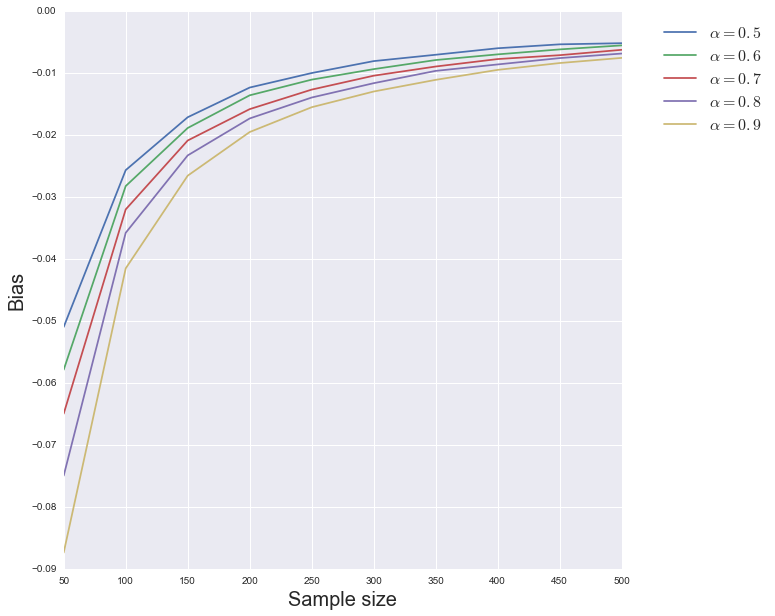

In [28]:
alpha_range = [.5, .6, .7, .8, .9]
samplesize_range = np.linspace(50, 500, 10).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i, a in enumerate(alpha_range):
    a_i = np.empty(len(samplesize_range))
    for j, n in enumerate(samplesize_range):
        a_i[j] = bias_n(a, b, sig, n, N)
    plt.plot(samplesize_range, a_i, label = r'$\alpha = {}$'.format(a))

plt.ylabel('Bias', fontsize = 20)
plt.xlabel('Sample size', fontsize = 20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon = False, fontsize = 16)
plt.show()

There are two main patterns that we see on the above graph.

>First, as we increase the sample size the simulated bias reduces for each value of $\alpha$. This is due to the fact that the OLS estimator is consistent and hence, asymptotically approaches the true value of the estimated parameter. As we increase the sample size the Law of Large Numbers kicks in and the bias gets smaller.

>Second, we see that as we increase the value of $\alpha$ the simulated bias get bigger for each sample size. This is due to the fact that the bias stems from the correlation between current innovation and future values of the AR1 process---in our case negative correlation as $\alpha$ is positive. The higher the $\alpha$ the stronger the impact of a change in the current innovation and the correlation which affects the bias gets bigger.  